In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [4]:
# ----- Build 1D Transverse Field Ising Hamiltonian -----
def build_ising_hamiltonian(n, J, h):
    paulis = []
    coeffs = []

    # Z_i Z_{i+1} term
    for i in range(n - 1):
        label = ['I'] * n
        label[i] = 'Z'
        label[i + 1] = 'Z'
        paulis.append(''.join(reversed(label)))  # Qiskit uses right-to-left order
        coeffs.append(-J)

    # X_i term
    for i in range(n):
        label = ['I'] * n
        label[i] = 'X'
        paulis.append(''.join(reversed(label)))
        coeffs.append(-h)

    return SparsePauliOp.from_list(list(zip(paulis, coeffs)))

In [5]:
def create_physically_inspired_ansatz(n_qubits, h, J, reps=3):
    params = ParameterVector('θ', length=2 * n_qubits * reps)
    qc = QuantumCircuit(n_qubits)

    # Initial state preparation: set RY angles according to h/J to simulate magnetization direction
    init_angle = 2 * np.arctan(h / J)  # Multiply by 2 because RY(θ)|0> = cos(θ/2)|0> + sin(θ/2)|1>
    for i in range(n_qubits):
        qc.ry(init_angle, i)

    # Ansatz part: multi-layer rotation + entanglement structure
    for rep in range(reps):
        for i in range(n_qubits):
            qc.ry(params[2 * n_qubits * rep + i], i)
            qc.rx(params[2 * n_qubits * rep + n_qubits + i], i)
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)

    return qc, list(params)

In [11]:
# Using Adagrad optimizer
'''optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # Learning rate can be adjusted'''

'optimizer = torch.optim.Adagrad(qnn_model.parameters(), lr=0.1)  # Learning rate can be adjusted'

In [7]:
# Using Stochastic Gradient Descent (SGD) optimizer
'''optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # Adjust learning rate as needed'''


'optimizer = torch.optim.SGD(qnn_model.parameters(), lr=0.01)  # Adjust learning rate as needed'

In [ ]:
# Calculate ground state energy and magnetization for N=2 to 10
results = []
for n_qubits in range(2, 11):
    J = 1.0
    h = 1.0
    hamiltonian = build_ising_hamiltonian(n_qubits, J, h)
    ansatz_circuit, ansatz_params = create_physically_inspired_ansatz(n_qubits, h, J, reps=4)
    estimator = Estimator()
    qnn = EstimatorQNN(
        circuit=ansatz_circuit,
        observables=hamiltonian,
        input_params=[],
        weight_params=ansatz_params,
        estimator=estimator
    )
    qnn_model = TorchConnector(qnn)
    optimizer = torch.optim.AdamW(qnn_model.parameters(), lr=0.01)
   
    # Train the model
    for epoch in range(500):  # Number of iterations can be adjusted
        optimizer.zero_grad()
        output = qnn_model()
        loss = output.mean()  # Optimize only the energy
        loss.backward()
        optimizer.step()

    # Record physical quantities with optimal parameters
    final_weights = qnn_model.weight.detach().numpy()
    estimator = Estimator()
    # <H> Ground state energy
    E0 = estimator.run(circuits=ansatz_circuit, observables=hamiltonian, parameter_values=[final_weights]).result().values[0]

    # <Z> Total magnetization
    z_obs = SparsePauliOp.from_list([(f"{'I'*i + 'Z' + 'I'*(n_qubits - i - 1)}", 1.0) for i in range(n_qubits)])
    mz = estimator.run(circuits=ansatz_circuit, observables=z_obs, parameter_values=[final_weights]).result().values[0] / n_qubits

    # <X> Total magnetization
    x_obs = SparsePauliOp.from_list([(f"{'I'*i + 'X' + 'I'*(n_qubits - i - 1)}", 1.0) for i in range(n_qubits)])
    mx = estimator.run(circuits=ansatz_circuit, observables=x_obs, parameter_values=[final_weights]).result().values[0] / n_qubits
    results.append((n_qubits, E0, mz, mx))
    
    print(f"N={n_qubits}, E0={E0:.6f}, <Z>={mz:.6f}, <X>={mx:.6f}")



/var/folders/d9/_3jh3gcd7m5gl50nsj1mgls80000gn/T/ipykernel_63559/3657267089.py:9: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


N=2, E0=-2.236068, <Z>=-0.000280, <X>=0.894504


In [9]:
# Summary output
print("\nSummary for N=2 to 10:")
for n, E0, mz, mx in results:
    print(f"N={n}: E0={E0:.6f}, <Z>={mz:.6f}, <X>={mx:.6f}")


Summary for N=2 to 10:
N=2: E0=-2.236068, <Z>=-0.000280, <X>=0.894504


## Visualize the Physically Inspired Ansatz Circuit

Below we plot the quantum circuit structure for the physically inspired ansatz used in this notebook (for N=4 as an example).

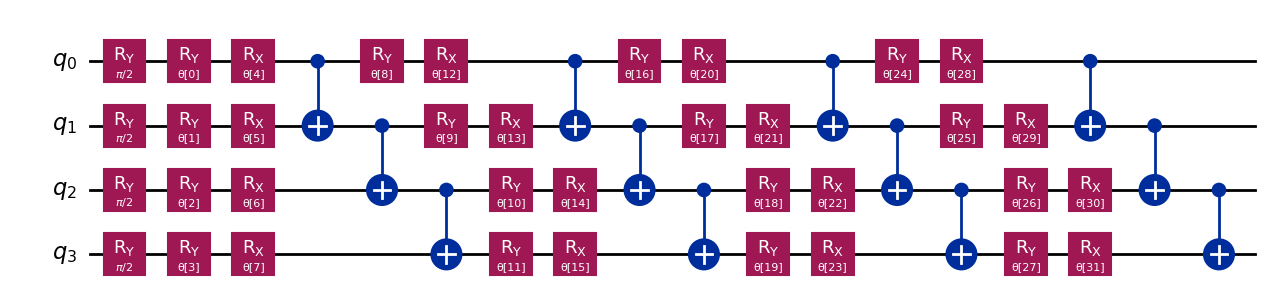

In [13]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

# Example: visualize the ansatz for N=4
n_qubits_example = 4
h_example = 1.0
J_example = 1.0
ansatz_circuit_example, _ = create_physically_inspired_ansatz(n_qubits_example, h_example, J_example, reps=4)

# Draw the circuit
circuit_drawer(ansatz_circuit_example, output='mpl')
plt.show()
circuit_drawer(ansatz_circuit_example, output='mpl', filename='my_circuit.png')

/var/folders/d9/_3jh3gcd7m5gl50nsj1mgls80000gn/T/ipykernel_63559/1091951540.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Finished N=2
Finished N=3
Finished N=3
Finished N=4
Finished N=4
Finished N=5
Finished N=5
Finished N=6
Finished N=6
Finished N=7
Finished N=7
Finished N=8
Finished N=8
Finished N=9
Finished N=9
Finished N=10
Finished N=10


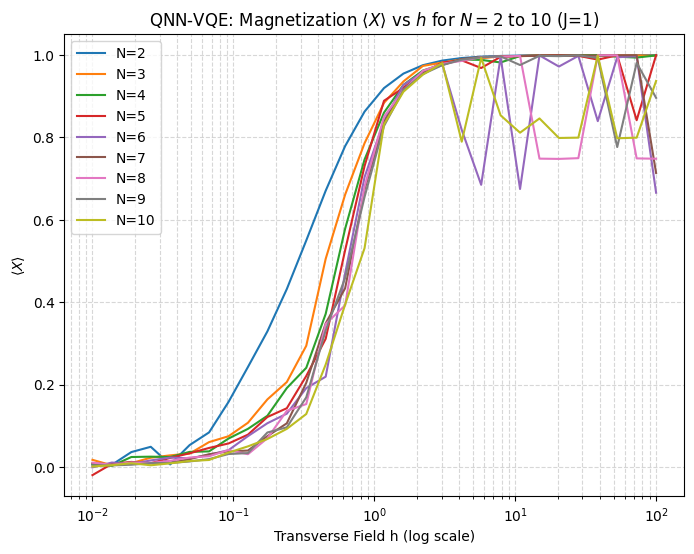

In [14]:
# Sweep h from 1e-2 to 1e2 and plot <X> vs h for N=2 to 10 using VQE/QNN
h_list = np.logspace(-2, 2, 30)
N_list = range(2, 11)
mx_vs_h = np.zeros((len(N_list), len(h_list)))

for iN, n_qubits in enumerate(N_list):
    for ih, h in enumerate(h_list):
        J = 1.0
        hamiltonian = build_ising_hamiltonian(n_qubits, J, h)
        ansatz_circuit, ansatz_params = create_physically_inspired_ansatz(n_qubits, h, J, reps=4)
        estimator = Estimator()
        qnn = EstimatorQNN(
            circuit=ansatz_circuit,
            observables=hamiltonian,
            input_params=[],
            weight_params=ansatz_params,
            estimator=estimator
        )
        qnn_model = TorchConnector(qnn)
        optimizer = torch.optim.AdamW(qnn_model.parameters(), lr=0.01)
        # Train the model
        for epoch in range(200):  # Reduce epochs for speed
            optimizer.zero_grad()
            output = qnn_model()
            loss = output.mean()
            loss.backward()
            optimizer.step()
        # <X> Total magnetization
        final_weights = qnn_model.weight.detach().numpy()
        x_obs = SparsePauliOp.from_list([(f"{'I'*i + 'X' + 'I'*(n_qubits - i - 1)}", 1.0) for i in range(n_qubits)])
        mx = estimator.run(circuits=ansatz_circuit, observables=x_obs, parameter_values=[final_weights]).result().values[0] / n_qubits
        mx_vs_h[iN, ih] = mx
    print(f"Finished N={n_qubits}")

plt.figure(figsize=(8,6))
for iN, N in enumerate(N_list):
    plt.plot(h_list, mx_vs_h[iN], label=f"N={N}")
plt.xscale('log')
plt.xlabel('Transverse Field h (log scale)')
plt.ylabel(r'$\langle X \rangle$')
plt.title(r'QNN-VQE: Magnetization $\langle X \rangle$ vs $h$ for $N=2$ to $10$ (J=1)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()